## Imports and Load data 

In [1]:
import cmlreaders as cml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import warnings; warnings.simplefilter('ignore')
pd.options.display.max_columns=None
pd.options.display.max_rows=100
from IPython.display import display, Markdown, HTML
import pandas_to_pybeh as pb
from tqdm import tqdm_notebook as lol
import time
import scipy
import rep_pybeh as rpb
from plotting import *
error_bars ={'elinewidth':3, 'capsize':5, 'capthick':3}


In [2]:
evs = []
for root, dire, files in os.walk('/data/behavioral/mturk/repFR/cleaned/'):
    for file in files:
        evs.append(pd.read_json(root+file))
evs = pd.concat(evs)
evs = evs[evs.listno != 0]
word_evs = evs[evs.type == 'WORD']
rec_evs = evs[evs.type == 'REC_WORD']

## SPC

In [7]:
spc = word_evs.groupby(['subject', 'listno', 'serialpos', 'repeats']).mean().reset_index().groupby(['subject', 'serialpos', 'repeats']).mean().reset_index()

spc = spc[['subject', 'serialpos', 'repeats', 'recalled']]
one_spc = spc.loc[spc.repeats == 1]
cuts = pd.qcut(one_spc.serialpos, 9)
one_spc = one_spc.groupby(['subject', cuts]).mean()


one_spc = one_spc.drop('serialpos', axis=1)
# one_spc.reset_index(inplace=True)
# one_spc.serialpos.apply(pd.Interval.left)
one_spc['spos_bins'] = (pd.IntervalIndex(one_spc.index.get_level_values('serialpos')).left+3)/3
one_spc['spos_bins'] = round(one_spc.spos_bins)
one_spc = one_spc.reset_index().drop('serialpos', 1)


sub_mean = one_spc.groupby(['subject', 'spos_bins', 'repeats']).recalled.mean().reset_index()
grand_mean = sub_mean.groupby(['spos_bins', 'repeats']).mean()
sub_mean = sub_mean.reset_index().set_index(['spos_bins', 'repeats'])
sub_mean['grand_mean'] = grand_mean
sub_mean['adjustment'] = sub_mean.grand_mean - sub_mean.recalled
sub_mean = sub_mean.reset_index().set_index(['subject', 'spos_bins', 'repeats'])
one_spc = one_spc.set_index(['subject', 'spos_bins', 'repeats'])
one_spc['adj_rec'] = one_spc.recalled + sub_mean['adjustment']
one_spc = one_spc.reset_index()
one_spc.to_csv('Mturk_spc.csv')

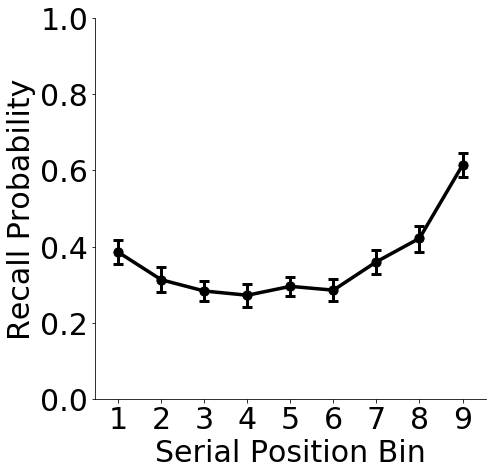

In [9]:
set_axes(fontsize = 30, ylim = [0,1], xticks=np.arange(1,10,1))
sns.lineplot(data = one_spc, x = 'spos_bins', y ='recalled', ci = 95, err_style = 'bars', color = 'black', 
             linewidth = 3.5, err_kws = error_bars)
sns.scatterplot(data = one_spc.groupby('spos_bins').mean().reset_index(), x = 'spos_bins', y = 'recalled', 
                color = 'black', s = 125)
plt.xlabel('Serial Position Bin')
plt.ylabel('Recall Probability')
plt.savefig('mturk_figs/spc.pdf', bbox_inches='tight')

## Repetition Effect

In [10]:
reps= word_evs.groupby(['subject', 'listno', 'repeats']).recalled.mean().reset_index()

In [13]:
reps = reps.groupby(['subject', 'repeats']).recalled.mean().reset_index()
display(reps.groupby(['repeats']).recalled.mean())
sub_mean = reps.groupby(['subject', 'repeats']).recalled.mean().reset_index()
grand_mean = sub_mean.groupby(['repeats']).mean()
sub_mean = sub_mean.reset_index().set_index(['repeats'])
sub_mean['grand_mean'] = grand_mean
sub_mean['adjustment'] = sub_mean.grand_mean - sub_mean.recalled
sub_mean = sub_mean.reset_index().set_index(['subject', 'repeats'])
reps = reps.set_index(['subject', 'repeats'])
reps['adj_rec'] = reps.recalled + sub_mean['adjustment']
reps = reps.reset_index()
reps.to_csv('Mturk_reps.csv')
# reps.groupby('repeats').recalled.mean()

repeats
1.0    0.359979
2.0    0.546391
3.0    0.705700
Name: recalled, dtype: float64

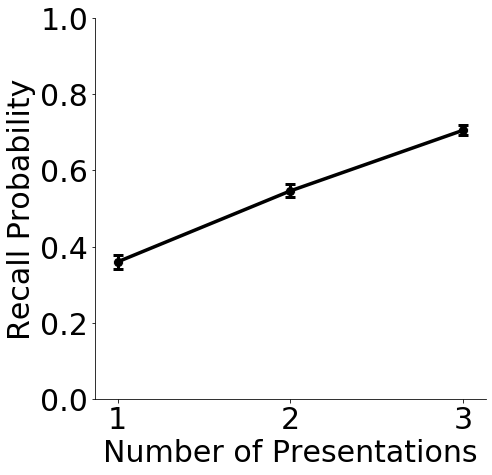

In [37]:
set_axes(fontsize = 30, ylim = [0,1], xticks = np.arange(1, 4, 1))
# g = sns.lineplot(data=scatter_reps, x = 'repeats', y = 'recalled', ci = 95, hue = 'subject', palette = palette, **dict(alpha=0.3), legend=None)

g = sns.lineplot(data=reps, x = 'repeats', y = 'recalled', err_style = 'bars',
                ci = 95, color = 'black', linewidth = 3.5, err_kws = error_bars)
g = sns.scatterplot(data=reps.groupby('repeats').mean().reset_index(), x = 'repeats', y = 'recalled', color = 'black', s= 100)
_ = plt.ylabel('Recall Probability')
_ = plt.xlabel('Number of Presentations')
plt.savefig('mturk_figs/recall_by_pres.pdf', bbox_inches='tight')

## Lag-CRP

In [ ]:
crp = []
num_lags = 8
for i, df in lol(evs.groupby('subject')):
    df = rpb.get_act_spos(df, list_type = 'listno', item_num = 'itemno')
    sub_crp = rpb.crp(df, num_lags = num_lags, list_length = 27, list_type = 'listno', item_num = 'itemno')
    crp.append(sub_crp)
crp = pd.concat(crp)
crp.reset_index(inplace = True)


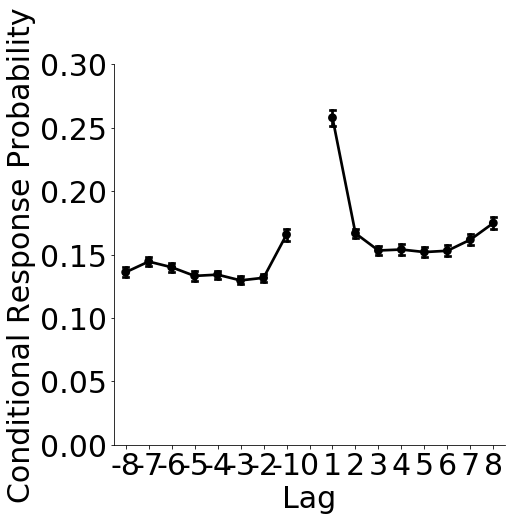

In [14]:
set_axes(ylim = [0, 0.3], fontsize = 30, xticks = np.arange(0, 8, 2))
sns.pointplot(data = crp , x = 'lag', y = 'prob', capsize = 0.2, color = 'black')
_ = plt.ylabel('Conditional Response Probability')
_ = plt.xlabel('Lag')
plt.savefig('mturk_figs/crp.pdf', bbox_inches='tight')

## Min Lag-CRP

In [18]:
min_crp = []
num_lags = 8
for i, df in lol(evs.groupby('subject')):
    df = rpb.get_act_spos(df, list_type = 'listno', item_num = 'itemno')
    sub_crp = rpb.min_crp(df, num_lags = num_lags, list_length = 27, list_type = 'listno', item_num = 'itemno')
    min_crp.append(sub_crp)
min_crp = pd.concat(min_crp)
min_crp.reset_index(inplace = True)
min_crp.to_csv('mturk_min_crp.csv')

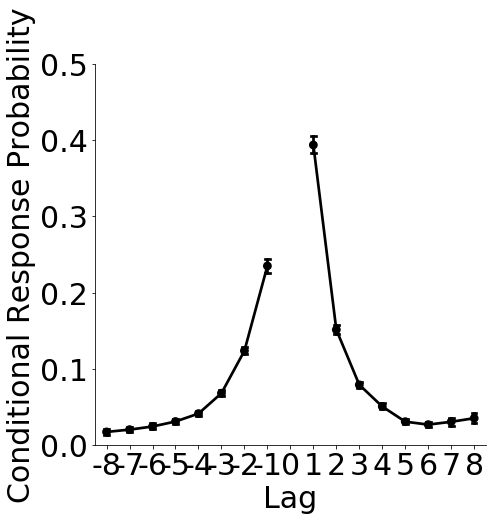

In [15]:
set_axes(ylim = [0, 0.5], fontsize = 30, xticks = np.arange(0, 8, 2))
sns.pointplot(data = min_crp , x = 'lag', y = 'prob', capsize = 0.2, color = 'black')
_ = plt.ylabel('Conditional Response Probability')
_ = plt.xlabel('Lag')
plt.savefig('mturk_figs/min_crp.pdf', bbox_inches='tight')

## Sem-CRP 

In [19]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

In [20]:
word_evs = evs.query('type == "WORD" and repeats != -999')
rec_evs = evs.query('type == "REC_WORD"')
#removing repeat presentations
word_evs = word_evs.drop_duplicates(subset=['subject', 'itemno'], keep='first')

In [21]:
events = word_evs.append(rec_evs)

In [22]:
# replace item nums so they are consistent across subjects
item_col = 'item'
item_num_col = 'itemno'
item_num_df = word_evs.drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
item_num_df[item_num_col] = item_num_df[item_num_col] + 1
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'), 
                          how='left', sort=False)#.sort_values('mstime')
events_new.fillna({item_num_col+'_new': -999}, inplace=True)

In [23]:
def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        similarity = keyed_vector.similarity(df[col1].lower(), df[col2].lower())
        return similarity
    except:
        return np.nan

In [24]:
# get all pairs of items
items = item_num_df[item_col].values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=[item_col+'_1', item_col+'_2']).to_frame(index=False)

In [25]:
# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1=item_col+'_1', 
               col2=item_col+'_2', 
               keyed_vector=word2vec_vectors)

In [26]:
sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on=item_col+'_1', right_on=item_col).merge(
    item_num_df, left_on=item_col+'_2', right_on=item_col, suffixes=('_1', '_2'))

In [27]:
sem_sims = pd.pivot_table(sem_sim_num_df, 
                          index=item_num_col+'_1', 
                          columns=item_num_col+'_2', 
                          values='similarity', dropna=False)

In [28]:
sem_sims

itemno_2,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312
itemno_1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.171647,0.038875,0.079164,0.047978,0.061012,0.129479,0.049773,0.172526,0.146993,0.134731,0.110920,0.095418,0.370968,-0.016880,0.250576,0.300725,0.109937,0.189824,0.136361,0.236835,0.150107,0.134082,0.297093,0.207323,0.128020,0.305980,0.056814,0.057583,0.098224,0.277828,0.090712,0.030991,0.196207,0.243242,0.082074,-0.015517,0.100779,0.049996,0.208645,0.194260,0.104983,0.139924,0.190021,0.159486,0.079298,0.123178,0.146326,0.087793,0.054711,0.097687,0.216449,0.062960,0.030893,0.076505,0.060947,0.213220,0.045743,0.196381,0.111865,0.149191,0.081938,0.111313,0.087177,0.130098,0.162097,0.199603,0.134156,0.380948,0.078623,0.050591,0.080702,0.130201,0.082926,0.132212,0.117129,0.199179,0.168043,0.180057,0.118888,0.201590,0.029276,0.265637,0.145787,0.188907,0.314375,0.159304,0.157591,0.133487,0.041725,0.142179,0.119261,0.197606,0.097526,0.184720,0.150043,0.153273,0.199325,0.141647,0.146851,0.063516,0.138394,0.150945,0.081375,0.107712,0.118999,0.099625,0.048249,0.213708,0.167116,0.190899,0.203766,0.066430,0.071314,0.392227,0.095812,0.100351,0.221627,0.053829,0.176096,0.106431,0.189992,0.086004,0.065819,0.099430,0.096265,0.084206,0.042028,0.171299,0.180763,0.008089,0.135188,0.096049,0.086984,0.095033,0.066913,0.121882,0.102836,0.017783,0.114928,0.120552,-0.003128,0.141208,0.077848,0.188828,0.076287,0.048621,0.063957,0.315433,0.243933,0.144105,0.189938,0.138811,0.017296,0.073708,0.058699,0.061237,-0.015757,0.176337,0.144961,0.241103,0.055793,0.057947,0.028985,-0.047201,0.086168,-0.007179,-0.026887,0.036320,0.163275,0.085649,0.107239,0.103910,0.164910,0.109724,0.075743,0.060662,0.418163,0.043686,0.157274,0.100615,0.179433,0.009881,0.114457,0.159109,0.124038,0.052591,-0.073000,0.242661,0.115652,0.038526,0.124229,-0.016505,0.242177,0.168875,0.078119,0.082542,0.146945,0.167910,0.102777,0.014040,0.110297,0.122152,0.135592,0.247921,0.141292,0.104675,0.104305,0.122045,0.138851,0.192129,0.007723,0.169973,0.067033,0.168881,0.044891,-0.005892,0.308590,0.059628,-0.001704,0.091370,0.190798,0.078293,0.060185,0.026243,0.160765,0.127224,0.080646,0.087172,0.135066,0.182365,0.081372,0.144906,0.067002,0.155192,0.101105,0.086355,0.006669,0.064302,0.141192,0.067104,0.101748,0.166624,0.090632,0.227501,0.158224,0.151281,0.089624,-0.018382,0.121717,0.134233,0.158771,0.176930,0.215910,-0.055433,0.050418,0.156784,0.166455,0.179103,0.164200,0.160560,0.111495,0.009946,0.147428,0.322738,0.130818,0.169023,0.102565,0.127119,0.167523,0.098606,0.118288,0.218809,0.057296,0.150615,0.202869,0.067314,0.014493,0.224669,0.05

In [30]:
# events_new.at[events_new.repeats == 2, 'item_num']

ones = events_new.copy()
ones.loc[ones.repeats == 2, item_num_col+'_new'] = -1
ones.loc[ones.repeats == 3, item_num_col+'_new'] = -1

twos = events_new.copy()
twos.loc[twos.repeats == 1, item_num_col+'_new'] = -1
twos.loc[twos.repeats == 3, item_num_col+'_new'] = -1

thrs = events_new.copy()
thrs.loc[thrs.repeats==1, 'item_num_new'] = -1
thrs.loc[thrs.repeats==2, 'item_num_new'] = -1

ones_crp = ones.groupby('subject').apply(pb.pd_sem_crp, itemno_column=item_num_col+'_new', 
                                         list_index=['subject', 'listno'], sem_sims=sem_sims).reset_index()
twos_crp = twos.groupby('subject').apply(pb.pd_sem_crp, itemno_column=item_num_col+'_new', 
                                         list_index=['subject', 'listno'], sem_sims=sem_sims).reset_index()
thrs_crp = thrs.groupby('subject').apply(pb.pd_sem_crp, itemno_column=item_num_col+'_new', 
                                         list_index=['subject', 'listno'], sem_sims=sem_sims).reset_index()
alls_crp = events_new.groupby('subject').apply(pb.pd_sem_crp, itemno_column=item_num_col+'_new', 
                                         list_index=['subject', 'listno'], sem_sims=sem_sims).reset_index()
alls_crp.to_csv('mturk_sem_crp.csv')

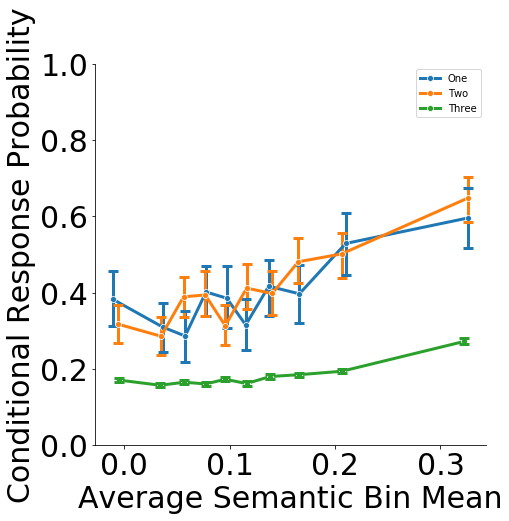

In [33]:
#using average bin value

ones_crp['avg_sem_bin_mean'] = ones_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
twos_crp['avg_sem_bin_mean'] = twos_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
thrs_crp['avg_sem_bin_mean'] = thrs_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
alls_crp['avg_sem_bin_mean'] = alls_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')


set_axes(ylim=[0, 1], xticks=np.arange(0, 0.41, 0.1), fontsize = 30)
g = sns.lineplot(x='avg_sem_bin_mean', y='prob', data=ones_crp, linewidth = 3,
                 marker = 'o', err_style = 'bars', err_kws=error_bars, label = 'One')

g = sns.lineplot(x='avg_sem_bin_mean', y='prob', data=twos_crp, linewidth = 3,
                 marker = 'o', err_style = 'bars', err_kws=error_bars, label = 'Two')

g = sns.lineplot(x='avg_sem_bin_mean', y='prob', data=thrs_crp, linewidth = 3,
                 marker = 'o', err_style = 'bars', err_kws=error_bars, label = 'Three')

plt.ylabel('Conditional Response Probability')
plt.xlabel('Average Semantic Bin Mean')
plt.savefig('mturk_figs/sem_crp_split.pdf', bbox_inches='tight')

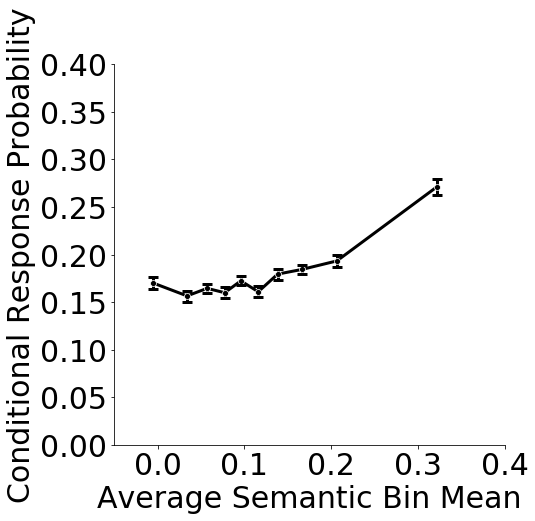

In [35]:
set_axes(ylim=[0, 0.4], xlim = [-0.05, 0.4], xticks=np.arange(0, 0.41, 0.1), fontsize = 30)

g = sns.lineplot(x='avg_sem_bin_mean', y='prob', data=alls_crp, linewidth = 3,
                 color = 'black', marker = 'o', err_style = 'bars', err_kws=error_bars)

plt.ylabel('Conditional Response Probability')
plt.xlabel('Average Semantic Bin Mean')

plt.savefig('mturk_figs/sem_crp.pdf', bbox_inches='tight')